In [11]:
# Rare Species Family Classifier - Deep Learning Project

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
# === 1. Paths ===
DATA_DIR = r'C:\Users\User\Desktop\deeplearning\dataset_split'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [14]:
# === 2. Image Parameters ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [15]:
# === 3. Image Data Generators ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

Found 8388 images belonging to 202 classes.
Found 1797 images belonging to 202 classes.
Found 1798 images belonging to 202 classes.


In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model

## VGG16 Model -----

In [17]:
def f1_score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_true, axis=1)
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [18]:
# === 4. Transfer Learning Model with VGG16 ===
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │        51,914 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,189,386 (80.83 MB)

 Trainable params: 6,474,698 (24.70 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
# === 5. Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [20]:
# === 6. Train frozen model ===
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
216/263 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - accuracy: 0.0180 - loss: 5.4538

c:\Users\User\anaconda3\envs\dl\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 722s 3s/step - accuracy: 0.0191 - loss: 5.4221 - val_accuracy: 0.0390 - val_loss: 5.0432 - learning_rate: 0.0010
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.0339 - loss: 5.0733 - val_accuracy: 0.0657 - val_loss: 4.8676 - learning_rate: 0.0010
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.0416 - loss: 4.9494 - val_accuracy: 0.0707 - val_loss: 4.7703 - learning_rate: 0.0010
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.0475 - loss: 4.8809 - val_accuracy: 0.0740 - val_loss: 4.6658 - learning_rate: 0.0010
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.0538 - loss: 4.8205 - val_accuracy: 0.0829 - val_loss: 4.6808 - learning_rate: 0.0010
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.0563 - loss: 4.8145 - val_accuracy: 0.0735 - val_loss: 4.6182 - learning_rate: 0.0010
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.0557 - loss: 4.8049 - val_

In [21]:
# === 7. Unfreeze for fine-tuning ===
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Fine-tune last few layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    epochs=60,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr],
    initial_epoch=history.epoch[-1] + 1
) 

Epoch 21/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 1227s 5s/step - accuracy: 0.0658 - loss: 4.6573 - val_accuracy: 0.0974 - val_loss: 4.4217 - learning_rate: 1.0000e-05
Epoch 22/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 1209s 5s/step - accuracy: 0.0617 - loss: 4.6588 - val_accuracy: 0.0985 - val_loss: 4.4045 - learning_rate: 1.0000e-05
Epoch 23/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 1203s 5s/step - accuracy: 0.0672 - loss: 4.5876 - val_accuracy: 0.1080 - val_loss: 4.3684 - learning_rate: 1.0000e-05
Epoch 24/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 1175s 4s/step - accuracy: 0.0633 - loss: 4.5886 - val_accuracy: 0.1080 - val_loss: 4.3542 - learning_rate: 1.0000e-05
Epoch 25/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 1204s 5s/step - accuracy: 0.0682 - loss: 4.5413 - val_accuracy: 0.1107 - val_loss: 4.3312 - learning_rate: 1.0000e-05
Epoch 26/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 1191s 5s/step - accuracy: 0.0660 - loss: 4.5252 - val_accuracy: 0.1091 - val_loss: 4.3743 - learning_rate: 1.0000e-05
Epoch 27/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 1178s

In [22]:
# === 7. Evaluation ===
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.4f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.3284 - loss: 3.2605
Test Accuracy: 0.2620


57/57 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
                              precision    recall  f1-score   support

           arthropoda_apidae       0.76      0.83      0.79        23
      arthropoda_attelabidae       0.00      0.00      0.00         4
        arthropoda_carabidae       0.00      0.00      0.00         9
     arthropoda_cerambycidae       0.00      0.00      0.00         5
   arthropoda_coenagrionidae       0.80      1.00      0.89         4
       arthropoda_formicidae       0.45      0.91      0.60        44
        arthropoda_gomphidae       0.00      0.00      0.00         9
        arthropoda_lucanidae       0.00      0.00      0.00         4
      arthropoda_nymphalidae       0.00      0.00      0.00         4
      arthropoda_palinuridae       0.00      0.00      0.00         4
     arthropoda_papilionidae       1.00      0.40      0.57         5
       arthropoda_pisauridae       0.00      0.00      0.00         5
   arthropoda_platystictidae       0.50      0.75

c:\Users\User\anaconda3\envs\dl\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\dl\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\dl\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


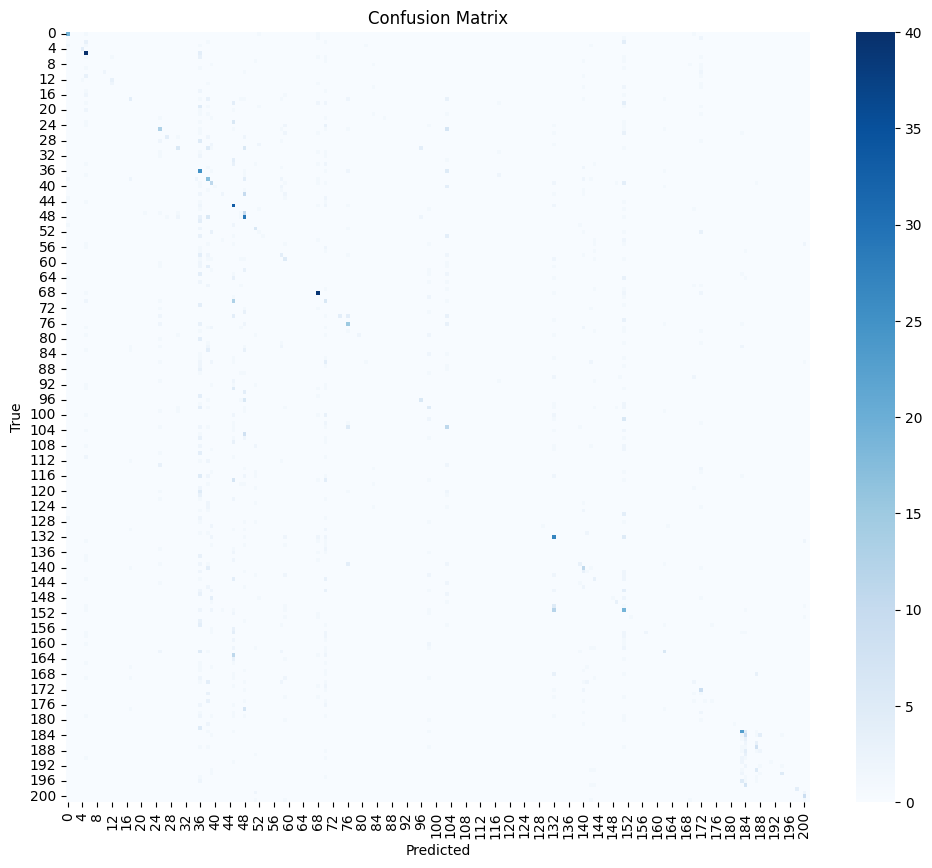

In [23]:
# === 8. Predictions & Metrics ===
preds = model.predict(test_gen)
y_true = test_gen.classes
y_pred = np.argmax(preds, axis=1)

# Classification report
target_names = [inv_class_indices[i] for i in sorted(inv_class_indices)]
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
# === 9. Save Model ===
model.save('efficientnet_species_classifier.h5')